In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
# Use dataset from data folder
dataset_path = "/kaggle/input/animal-dataset/animal_dataset"
if os.path.exists(dataset_path):
    print("Dataset found in data folder!")
else:
    print("Dataset not found. Please ensure animal_dataset exists in data folder.")

Dataset found in data folder!


In [4]:
dataset_path = "/kaggle/input/animal-dataset/animal_dataset"
animals = sorted(os.listdir(dataset_path))
print(f"Classes found: {animals}")

Classes found: ['cat', 'dog', 'panda']


In [5]:
selected_images = {}
for animal in animals:
    animal_path = os.path.join(dataset_path, animal)
    images = os.listdir(animal_path)
    selected_images[animal] = images
    print(f"{animal}: {len(images)} images")

cat: 100 images
dog: 100 images
panda: 100 images


In [6]:
image_size = 32
images_count = 100
k_values = list(range(2, 20))

In [7]:
X_train = []
y_train = []

for label, animal in enumerate(animals):
    animal_path = os.path.join(dataset_path, animal)
    for i, img_name in enumerate(selected_images[animal][:images_count]):
        img_path = os.path.join(animal_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img.flatten())
        y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Total images: {len(X_train)}")

Training data shape: (300, 1024)
Training labels shape: (300,)
Total images: 300


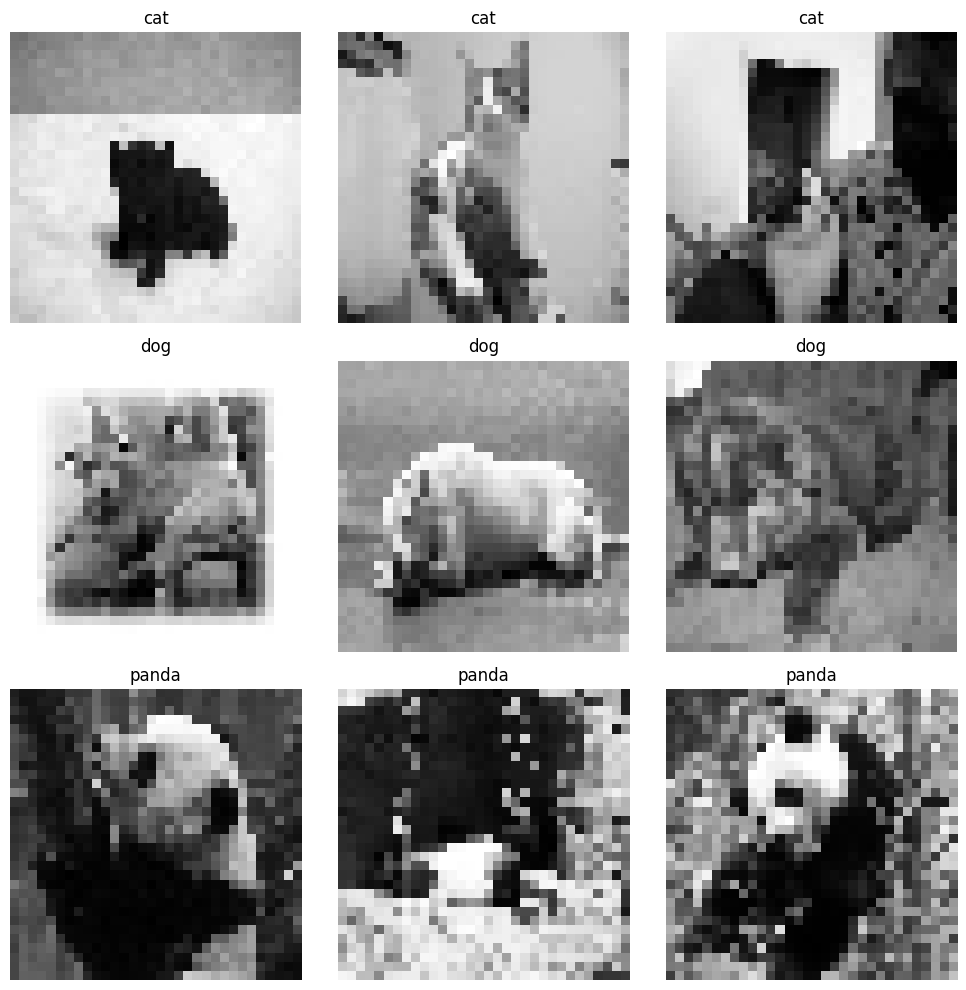

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, animal in enumerate(animals):
    for j in range(3):
        idx = i * images_count + j
        axes[i, j].imshow(X_train[idx].reshape(image_size, image_size), cmap='gray')
        axes[i, j].set_title(f"{animal}")
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

In [9]:
def l1_distance(X_train, x_test):
    """Calculate L1 (Manhattan) distance between test sample and all training samples."""
    return np.sum(np.abs(X_train - x_test), axis=1)

def l2_distance(X_train, x_test):
    """Calculate L2 (Euclidean) distance between test sample and all training samples."""
    return np.sqrt(np.sum((X_train - x_test)**2, axis=1))

In [10]:
def predict(X_train, y_train, x_test, k, distance_metric='l2'):
    """Predict class label for a test sample using KNN."""
    if distance_metric == 'l1':
        distances = l1_distance(X_train, x_test)
    else:
        distances = l2_distance(X_train, x_test)
    
    # Get indices of k nearest neighbors
    k_nearest_indices = np.argsort(distances)[:k]
    k_nearest_labels = y_train[k_nearest_indices]
    
    # Majority voting
    prediction = np.bincount(k_nearest_labels).argmax()
    return prediction

In [11]:
def cross_validation(X, y, k_values, n_folds=5, distance_metric='l2'):
    """Perform k-fold cross-validation for different K values."""
    fold_size = len(X) // n_folds
    accuracies = {k: [] for k in k_values}
    
    for fold in range(n_folds):
        # Create validation fold
        val_start = fold * fold_size
        val_end = val_start + fold_size
        
        # Split data
        X_val = X[val_start:val_end]
        y_val = y[val_start:val_end]
        X_train_fold = np.concatenate([X[:val_start], X[val_end:]])
        y_train_fold = np.concatenate([y[:val_start], y[val_end:]])
        
        # Test each K value
        for k in k_values:
            correct = 0
            for i in range(len(X_val)):
                pred = predict(X_train_fold, y_train_fold, X_val[i], k, distance_metric)
                if pred == y_val[i]:
                    correct += 1
            accuracy = correct / len(X_val)
            accuracies[k].append(accuracy)
        
        print(f"Fold {fold + 1}/{n_folds} completed")
    
    # Calculate average accuracy for each K
    avg_accuracies = {k: np.mean(accuracies[k]) for k in k_values}
    return avg_accuracies

In [12]:
print("Running 5-fold cross-validation with L2 (Euclidean) distance...")
accuracies_l2 = cross_validation(X_train, y_train, k_values, n_folds=5, distance_metric='l2')

# Find best K
best_k_l2 = max(accuracies_l2, key=accuracies_l2.get)
best_accuracy_l2 = accuracies_l2[best_k_l2]

print(f"\nBest K (L2): {best_k_l2}")
print(f"Best Accuracy (L2): {best_accuracy_l2:.4f}")

Running 5-fold cross-validation with L2 (Euclidean) distance...
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed
Fold 5/5 completed

Best K (L2): 4
Best Accuracy (L2): 0.2100


In [13]:
print("Running 5-fold cross-validation with L1 (Manhattan) distance...")
accuracies_l1 = cross_validation(X_train, y_train, k_values, n_folds=5, distance_metric='l1')

# Find best K
best_k_l1 = max(accuracies_l1, key=accuracies_l1.get)
best_accuracy_l1 = accuracies_l1[best_k_l1]

print(f"\nBest K (L1): {best_k_l1}")
print(f"Best Accuracy (L1): {best_accuracy_l1:.4f}")

Running 5-fold cross-validation with L1 (Manhattan) distance...
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed
Fold 5/5 completed

Best K (L1): 2
Best Accuracy (L1): 0.2733


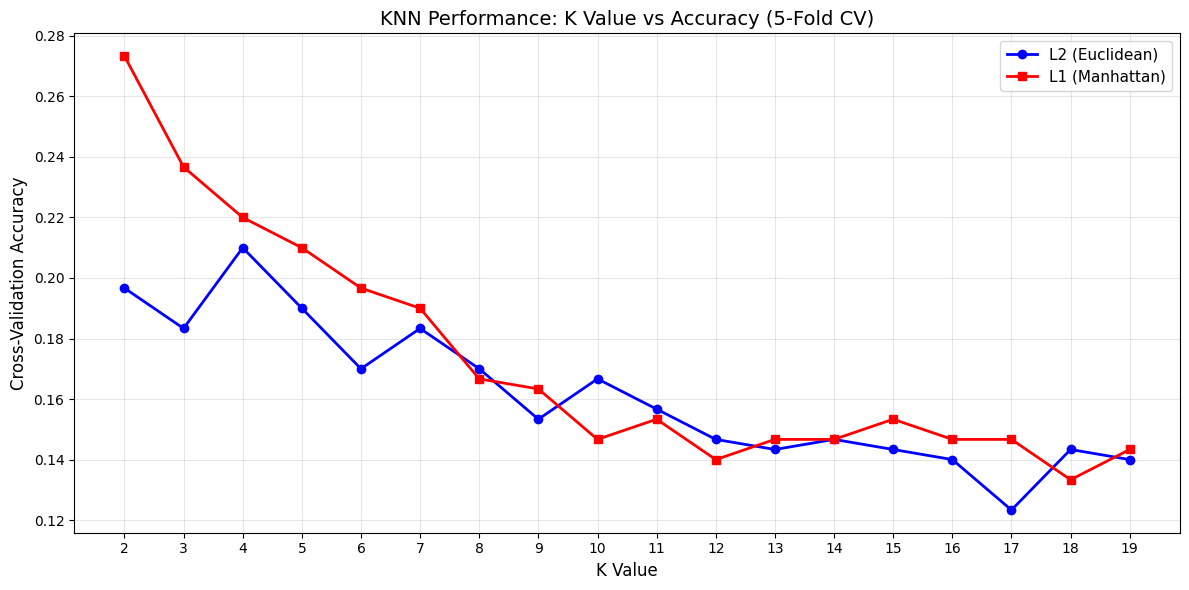


=== Final Results ===
L2 Distance: Best K = 4, Accuracy = 0.2100
L1 Distance: Best K = 2, Accuracy = 0.2733


In [14]:
plt.figure(figsize=(12, 6))
plt.plot(k_values, [accuracies_l2[k] for k in k_values], 'b-o', label='L2 (Euclidean)', linewidth=2)
plt.plot(k_values, [accuracies_l1[k] for k in k_values], 'r-s', label='L1 (Manhattan)', linewidth=2)
plt.xlabel('K Value', fontsize=12)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.title('KNN Performance: K Value vs Accuracy (5-Fold CV)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.tight_layout()
plt.show()

print(f"\n=== Final Results ===")
print(f"L2 Distance: Best K = {best_k_l2}, Accuracy = {best_accuracy_l2:.4f}")
print(f"L1 Distance: Best K = {best_k_l1}, Accuracy = {best_accuracy_l1:.4f}")

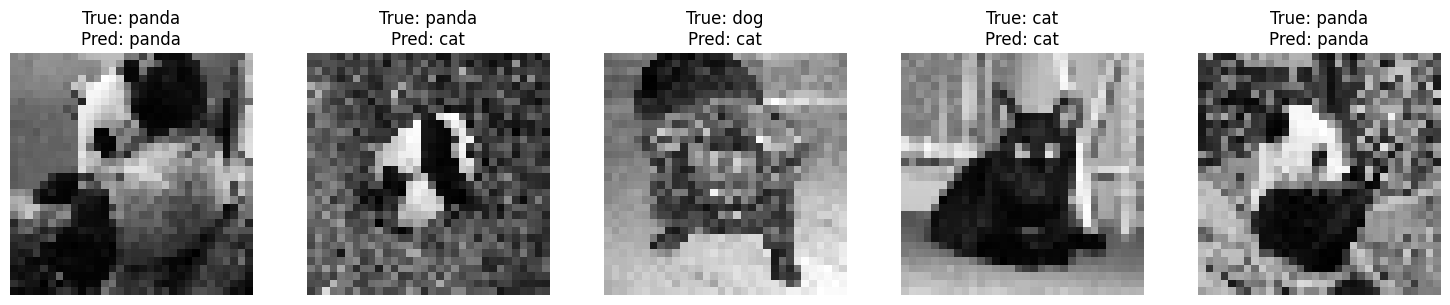

In [15]:
# Select 5 random test samples
np.random.seed(42)
test_indices = np.random.choice(len(X_train), 5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for idx, test_idx in enumerate(test_indices):
    # Make prediction
    pred = predict(X_train, y_train, X_train[test_idx], best_k_l2, 'l2')
    true_label = y_train[test_idx]
    
    # Display image
    axes[idx].imshow(X_train[test_idx].reshape(image_size, image_size), cmap='gray')
    axes[idx].set_title(f"True: {animals[true_label]}\nPred: {animals[pred]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()